In [35]:
#Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

import openmeteo_requests
import requests_cache
from retry_requests import retry


In [36]:

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.85,
	"longitude": -87.65,
	"start_date": "2012-01-01",
	"end_date": "2017-12-31",
	"hourly": "temperature_2m",
	"daily": ["temperature_2m_max", "temperature_2m_min"],
	"temperature_unit": "fahrenheit"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 41.8629150390625°E -87.64877319335938°N
Elevation 179.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                     date  temperature_2m
0     2012-01-01 00:00:00       38.581699
1     2012-01-01 01:00:00       38.041698
2     2012-01-01 02:00:00       38.041698
3     2012-01-01 03:00:00       38.491699
4     2012-01-01 04:00:00       39.211700
...                   ...             ...
52603 2017-12-31 19:00:00       12.661701
52604 2017-12-31 20:00:00       13.471699
52605 2017-12-31 21:00:00       12.661701
52606 2017-12-31 22:00:00       10.411701
52607 2017-12-31 23:00:00        8.071699

[52608 rows x 2 columns]


In [37]:

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min

daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe




,date,temperature_2m_max,temperature_2m_min
0,2012-01-01,44.071701,32.551701
1,2012-01-02,32.011700,23.191700
2,2012-01-03,25.891701,16.981701
3,2012-01-04,38.131699,25.891701
4,2012-01-05,43.531700,30.211700
...,...,...,...
2187,2017-12-27,10.051701,-1.918301
2188,2017-12-28,16.531700,1.681698
2189,2017-12-29,15.811701,1.231699
2190,2017-12-30,14.281700,0.151699


In [38]:
#Renaming Date
daily_dataframe_2 = daily_dataframe.rename(columns={'date': 'Date'})
daily_dataframe_2.head()

,Date,temperature_2m_max,temperature_2m_min
0,2012-01-01,44.071701,32.551701
1,2012-01-02,32.011700,23.191700
2,2012-01-03,25.891701,16.981701
3,2012-01-04,38.131699,25.891701
4,2012-01-05,43.531700,30.211700


In [39]:
daily_dataframe_2['Date'] = pd.to_datetime(daily_dataframe_2['Date']).dt.date
daily_dataframe_2.head()

,Date,temperature_2m_max,temperature_2m_min
0,2012-01-01,44.071701,32.551701
1,2012-01-02,32.011700,23.191700
2,2012-01-03,25.891701,16.981701
3,2012-01-04,38.131699,25.891701
4,2012-01-05,43.531700,30.211700


In [40]:
#Study data files
crime_data_path='Chicago_Crimes_2012_to_2017.csv'

#Reading CSV
crime_data=pd.read_csv(crime_data_path)
#Copyng the data
crime_data_copy=crime_data.copy()
#Read the crime data to analysis
crime_data.sample(5)


,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
883079,3218461,9741550,HX392092,08/18/2014 07:45:00 AM,017XX W WASHINGTON BLVD,0820,THEFT,$500 AND UNDER,CTA BUS STOP,False,...,27.0,28.0,06,1164979.0,1900747.0,2014,02/04/2016 06:33:39 AM,41.883255,-87.669644,"(41.883255206, -87.669644115)"
560480,2895467,9199948,HW345089,07/02/2013 02:58:00 PM,085XX S INGLESIDE AVE,0460,BATTERY,SIMPLE,SIDEWALK,False,...,8.0,44.0,08B,1184042.0,1848646.0,2013,02/04/2016 06:33:39 AM,41.739860,-87.601274,"(41.739860331, -87.601274245)"
1167910,3504451,10320053,HY499530,11/12/2015 07:40:00 PM,042XX W IRVING PARK RD,5011,OTHER OFFENSE,LICENSE VIOLATION,BAR OR TAVERN,False,...,38.0,16.0,26,1147576.0,1926251.0,2015,11/26/2015 03:54:17 PM,41.953592,-87.732894,"(41.953592191, -87.7328937)"
895790,3231173,9763035,HX413230,09/02/2014 10:55:00 PM,026XX W 63RD ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,...,15.0,66.0,18,1159659.0,1862774.0,2014,02/04/2016 06:33:39 AM,41.779164,-87.690223,"(41.779164139, -87.690223372)"
1234359,4053991,10437191,HZ175012,03/04/2016 07:00:00 AM,017XX E 92ND ST,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,...,8.0,48.0,05,1189373.0,1844316.0,2016,03/11/2016 03:51:59 PM,41.727852,-87.581881,"(41.727852278, -87.581881003)"


In [41]:
#Checking if the data have duplicates serching from the ID
dup_crime_data=crime_data.loc[crime_data.duplicated(subset=['ID']),'ID'].unique()
dup_crime_data
#Don't have any duplicate data

array([], dtype=int64)

In [42]:
#See if have blank columns
crime_data.empty

False

In [43]:
#Checking the type of crimes and number with all years together
crime_data['Primary Type'].value_counts()

Primary Type
THEFT                                329460
BATTERY                              263700
CRIMINAL DAMAGE                      155455
NARCOTICS                            135240
ASSAULT                               91289
OTHER OFFENSE                         87874
BURGLARY                              83397
DECEPTIVE PRACTICE                    75495
MOTOR VEHICLE THEFT                   61138
ROBBERY                               57313
CRIMINAL TRESPASS                     36912
WEAPONS VIOLATION                     17233
PUBLIC PEACE VIOLATION                13122
OFFENSE INVOLVING CHILDREN            11398
PROSTITUTION                           7633
CRIM SEXUAL ASSAULT                    6823
INTERFERENCE WITH PUBLIC OFFICER       6195
SEX OFFENSE                            4885
HOMICIDE                               2649
ARSON                                  2217
GAMBLING                               2212
LIQUOR LAW VIOLATION                   1953
KIDNAPPING         

In [44]:
#Get the name of columns to clean up
list(crime_data.columns) 

['Unnamed: 0',
 'ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [45]:
#Cleaning up some columns (If you guys think need to cleaning up more just include the name of the column on the code)
crime_data_copy=crime_data_copy.drop(['Unnamed: 0','Case Number','Block','IUCR','Description','Location Description','Arrest','Domestic','Beat','Ward','FBI Code','X Coordinate',
                                      'Y Coordinate','Updated On','Latitude','Longitude','Location'], axis=1)
crime_data_copy.head()


,ID,Date,Primary Type,District,Community Area,Year
0,10508693,05/03/2016 11:40:00 PM,BATTERY,10.0,29.0,2016
1,10508695,05/03/2016 09:40:00 PM,BATTERY,3.0,42.0,2016
2,10508697,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,15.0,25.0,2016
3,10508698,05/03/2016 10:10:00 PM,BATTERY,15.0,25.0,2016
4,10508699,05/03/2016 10:00:00 PM,THEFT,15.0,25.0,2016


In [46]:
#Crimes group by year and type
#crime_data_yearly=crime_data_copy.groupby(['Year','Primary Type'])

#crime_data_yearly.count()

In [47]:
#filtering out types of crimes except 'ASSAULT', 'BATTERY', 'CRIM SEXUAL ASSAULT', or 'HOMICIDE'
desired_types = ['ASSAULT', 'BATTERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE']
cleaned_df = crime_data_copy[crime_data_copy['Primary Type'].isin(desired_types)]
print(cleaned_df)

               ID                    Date Primary Type  District  \
0        10508693  05/03/2016 11:40:00 PM      BATTERY      10.0   
1        10508695  05/03/2016 09:40:00 PM      BATTERY       3.0   
3        10508698  05/03/2016 10:10:00 PM      BATTERY      15.0   
5        10508702  05/03/2016 10:35:00 PM      BATTERY       6.0   
6        10508703  05/03/2016 10:30:00 PM      BATTERY       1.0   
...           ...                     ...          ...       ...   
1456706  10508672  05/03/2016 10:25:00 PM      BATTERY       8.0   
1456708  10508678  05/03/2016 11:28:00 PM      BATTERY      22.0   
1456709  10508679  05/03/2016 11:33:00 PM      BATTERY      10.0   
1456711  10508681  05/03/2016 12:15:00 AM      BATTERY       8.0   
1456712  10508690  05/03/2016 09:07:00 PM      BATTERY       4.0   

         Community Area  Year  
0                  29.0  2016  
1                  42.0  2016  
3                  25.0  2016  
5                  44.0  2016  
6                  35.0

In [48]:
# Adjusting the Date to correct format we need for merge
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date']).dt.date
cleaned_df.sample(10)

/var/folders/v9/050_tbp1629_y7rj_k5r6vnh0000gn/T/ipykernel_21163/1008598738.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date']).dt.date
/var/folders/v9/050_tbp1629_y7rj_k5r6vnh0000gn/T/ipykernel_21163/1008598738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date']).dt.date


,ID,Date,Primary Type,District,Community Area,Year
1325036,10614434,2016-07-27,BATTERY,11.0,27.0,2016
132550,8514501,2012-03-10,BATTERY,8.0,65.0,2012
536388,9161721,2013-06-06,ASSAULT,17.0,16.0,2013
391620,8926466,2012-12-11,BATTERY,11.0,28.0,2012
321348,8814138,2012-09-22,ASSAULT,22.0,49.0,2012
143414,8531864,2012-03-22,BATTERY,7.0,67.0,2012
784714,9577953,2014-04-18,BATTERY,15.0,25.0,2014
753857,9521315,2014-03-07,ASSAULT,4.0,51.0,2014
1000616,10027430,2015-04-10,BATTERY,6.0,71.0,2015
1433217,10785706,2016-12-16,ASSAULT,11.0,27.0,2016


In [49]:
#merging the two data frames

merged_df = pd.merge(cleaned_df, daily_dataframe_2, on='Date', how='left')
merged_df.sample(7)



,ID,Date,Primary Type,District,Community Area,Year,temperature_2m_max,temperature_2m_min
313994,20380,2012-04-22,HOMICIDE,7.0,67.0,2012,48.031700,43.621700
64031,8706265,2012-07-13,BATTERY,3.0,42.0,2012,88.981705,75.841705
45600,8597068,2012-05-04,BATTERY,22.0,75.0,2012,67.651703,55.951702
79061,8803605,2012-09-15,BATTERY,12.0,24.0,2012,73.861702,59.911701
312858,10112004,2015-06-14,BATTERY,4.0,46.0,2015,78.451698,69.181702
302755,10420104,2016-02-20,BATTERY,25.0,25.0,2016,53.341702,40.021698
344718,10701324,2016-10-01,BATTERY,22.0,75.0,2016,62.341702,59.641701


In [50]:
#Crimes group by year and type updated with only desired crime types 
crime_data_yearly=cleaned_df.groupby(['Year','Primary Type'])

crime_data_yearly.count()

ID   Date  District  Community Area
Year Primary Type                                               
2012 ASSAULT              19898  19898     19898           19894
     BATTERY              59132  59132     59132           59129
     CRIM SEXUAL ASSAULT   1406   1406      1406            1406
     HOMICIDE               503    503       503             503
2013 ASSAULT              17971  17971     17971           17971
     BATTERY              54003  54003     54003           54003
     CRIM SEXUAL ASSAULT   1264   1264      1264            1264
     HOMICIDE               422    422       422             422
2014 ASSAULT              16896  16896     16896           16896
     BATTERY              49444  49444     49444           49444
     CRIM SEXUAL ASSAULT   1305   1305      1305            1305
     HOMICIDE               424    424       424             424
2015 ASSAULT              17040  17040     17040           17040
     BATTERY              48904  48904     48904           48904
     CRIM SEXUAL ASSAULT   1339   1339      1339            1339
     HOMICIDE               497    497       497             497
2016 ASSAULT              18710  18710     18710           18710
     BATTERY              50243  50243     50243           50243
     CRIM SEXUAL ASSAULT   1445   1445      1445            1445
     HOMICIDE               772    772       772             772
2017 ASSAULT                774    774       774             774
     BATTERY               1974   1974      1974            1974
     CRIM SEXUAL ASSAULT     64     64        64              64
     HOMICIDE                31     31        31              31

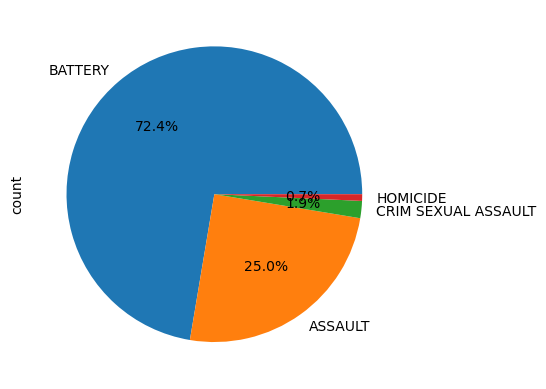

In [51]:
#pie chart-- overall 
crime_type = cleaned_df["Primary Type"].value_counts()
crime_type.plot(kind="pie",autopct="%1.1f%%")
plt.show()

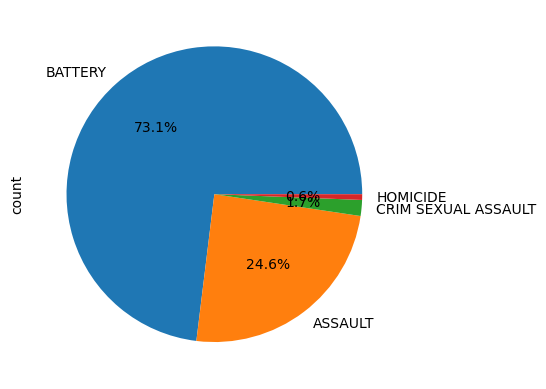

In [52]:
# Pie Charts by year-- 2012
year_of_interest_2012 = 2012
data_for_year_2012 = merged_df[merged_df['Year'] == year_of_interest_2012]

pie2012 = data_for_year_2012["Primary Type"].value_counts()
pie2012.plot(kind="pie",autopct="%1.1f%%")
plt.show()

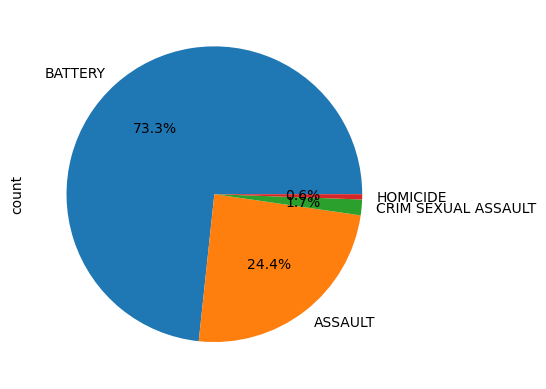

In [53]:
# Pie Charts by year-- 2013
year_of_interest_2013 = 2013
data_for_year_2013 = merged_df[merged_df['Year'] == year_of_interest_2013]

pie_2013 = data_for_year_2013["Primary Type"].value_counts()
pie_2013.plot(kind="pie",autopct="%1.1f%%")
plt.show()

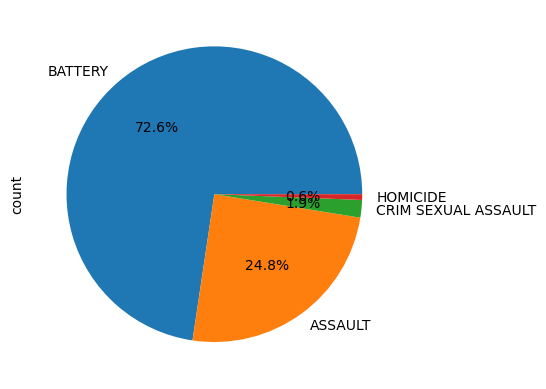

In [54]:
# Pie Charts by year-- 2014
year_of_interest_2014 = 2014
data_for_year_2014 = merged_df[merged_df['Year'] == year_of_interest_2014]

pie_2014 = data_for_year_2014["Primary Type"].value_counts()
pie_2014.plot(kind="pie",autopct="%1.1f%%")
plt.show()

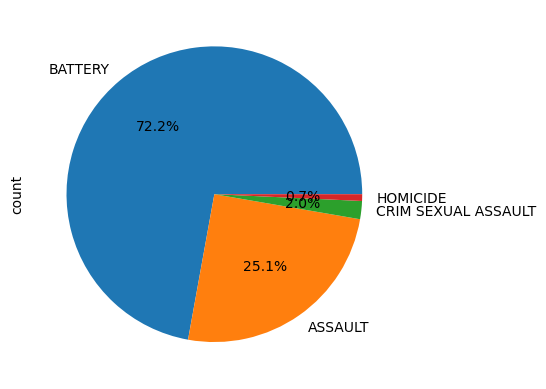

In [55]:
# Pie Charts by year-- 2015
year_of_interest_2015 = 2015
data_for_year_2015 = merged_df[merged_df['Year'] == year_of_interest_2015]

pie_2015 = data_for_year_2015["Primary Type"].value_counts()
pie_2015.plot(kind="pie",autopct="%1.1f%%")
plt.show()

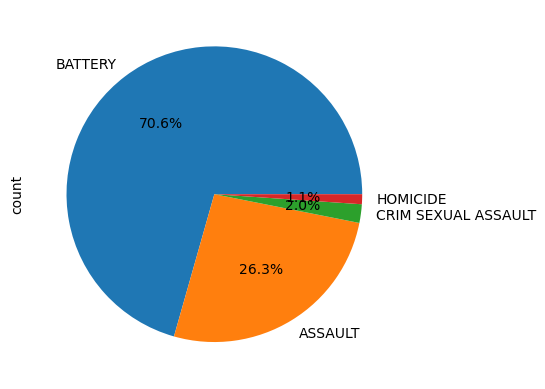

In [56]:
# Pie Charts by year-- 2016
year_of_interest_2016 = 2016
data_for_year_2016 = merged_df[merged_df['Year'] == year_of_interest_2016]

pie_2016 = data_for_year_2016["Primary Type"].value_counts()
pie_2016.plot(kind="pie",autopct="%1.1f%%")
plt.show()

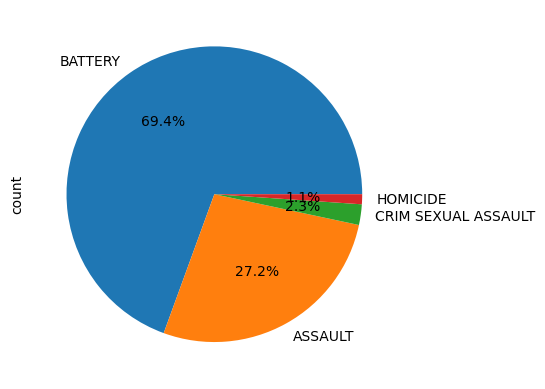

In [57]:
# Pie Charts by year-- 2017
year_of_interest_2017 = 2017
data_for_year_2017 = merged_df[merged_df['Year'] == year_of_interest_2017]

pie_2017 = data_for_year_2017["Primary Type"].value_counts()
pie_2017.plot(kind="pie",autopct="%1.1f%%")
plt.show()

In [58]:
#Primary Assault Table by Date
assault_table = merged_df.groupby(['Date']).count()['ID'].reset_index()
assault_table

,Date,ID
0,2012-01-01,350
1,2012-01-02,154
2,2012-01-03,166
3,2012-01-04,142
4,2012-01-05,183
...,...,...
1840,2017-01-14,174
1841,2017-01-15,165
1842,2017-01-16,171
1843,2017-01-17,143


In [59]:
#Temperature Table by date
temp_data = merged_df[['Date','temperature_2m_max','temperature_2m_min']]
temperature_table = temp_data.groupby(['Date']).mean().reset_index()
temperature_table

,Date,temperature_2m_max,temperature_2m_min
0,2012-01-01,44.071701,32.551701
1,2012-01-02,32.011700,23.191700
2,2012-01-03,25.891701,16.981701
3,2012-01-04,38.131699,25.891701
4,2012-01-05,43.531700,30.211700
...,...,...,...
1840,2017-01-14,33.721699,26.431700
1841,2017-01-15,34.171700,18.961699
1842,2017-01-16,36.151699,28.141701
1843,2017-01-17,42.451698,34.351700


In [60]:
graph_data = pd.merge(temperature_table, assault_table, on='Date')
graph_data

,Date,temperature_2m_max,temperature_2m_min,ID
0,2012-01-01,44.071701,32.551701,350
1,2012-01-02,32.011700,23.191700,154
2,2012-01-03,25.891701,16.981701,166
3,2012-01-04,38.131699,25.891701,142
4,2012-01-05,43.531700,30.211700,183
...,...,...,...,...
1840,2017-01-14,33.721699,26.431700,174
1841,2017-01-15,34.171700,18.961699,165
1842,2017-01-16,36.151699,28.141701,171
1843,2017-01-17,42.451698,34.351700,143


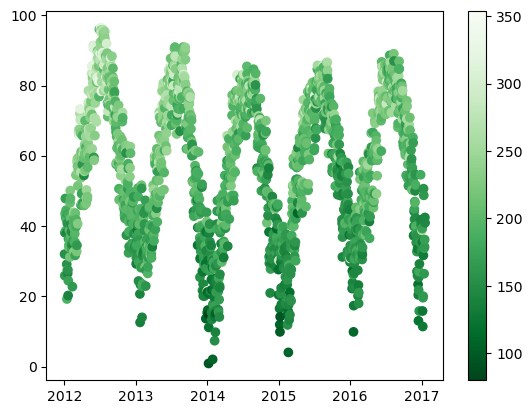

In [72]:
#crime_type_test = data_for_year["Primary Type"].value_counts()
plt.scatter(graph_data['Date'],graph_data['temperature_2m_max'], c=graph_data['ID'], cmap='Greens_r')
clb = plt.colorbar()
plt.show()

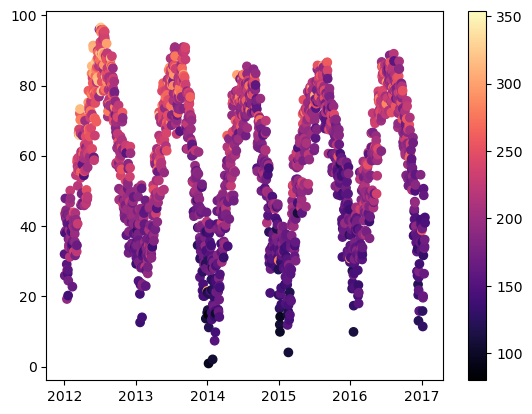

In [70]:
#crime_type_test = data_f["Primary Type"].value_counts()
plt.scatter(graph_data['Date'], graph_data['temperature_2m_max'], c=graph_data["ID"], cmap='magma')
clb = plt.colorbar()
plt.show()

In [65]:
#Finding Max & Min Temp across all the Data
max_value = merged_df['temperature_2m_max'].max()
max_value

min_value = merged_df['temperature_2m_min'].min()
min_value

f'Max Temp is {max_value}, Min Temp is {min_value}'

'Max Temp is 96.54170227050781, Min Temp is -15.058296203613281'

In [66]:
#creating bins
temperature_bins = [-15, -5, 5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 120]
# Create the names for the bins
bin_names = ["-15° : -5°", "-4° : 5°", "6° : 15°", "16° : 25°", "26° : 35°", "36° : 45°", "46° : 55°", "56° : 65°", "66° : 75°", "76° : 85°", "86° : 95°", "96° : 120°"]


merged_df["Temperature Ranges"] = pd.cut(merged_df["temperature_2m_min"],
                                              temperature_bins, labels=bin_names,
                                              include_lowest=True)
merged_df



,ID,Date,Primary Type,District,Community Area,Year,temperature_2m_max,temperature_2m_min,Temperature Ranges
0,10508693,2016-05-03,BATTERY,10.0,29.0,2016,61.801701,41.731701,36° : 45°
1,10508695,2016-05-03,BATTERY,3.0,42.0,2016,61.801701,41.731701,36° : 45°
2,10508698,2016-05-03,BATTERY,15.0,25.0,2016,61.801701,41.731701,36° : 45°
3,10508702,2016-05-03,BATTERY,6.0,44.0,2016,61.801701,41.731701,36° : 45°
4,10508703,2016-05-03,BATTERY,1.0,35.0,2016,61.801701,41.731701,36° : 45°
...,...,...,...,...,...,...,...,...,...
364456,10508672,2016-05-03,BATTERY,8.0,66.0,2016,61.801701,41.731701,36° : 45°
364457,10508678,2016-05-03,BATTERY,22.0,71.0,2016,61.801701,41.731701,36° : 45°
364458,10508679,2016-05-03,BATTERY,10.0,30.0,2016,61.801701,41.731701,36° : 45°
364459,10508681,2016-05-03,BATTERY,8.0,66.0,2016,61.801701,41.731701,36° : 45°


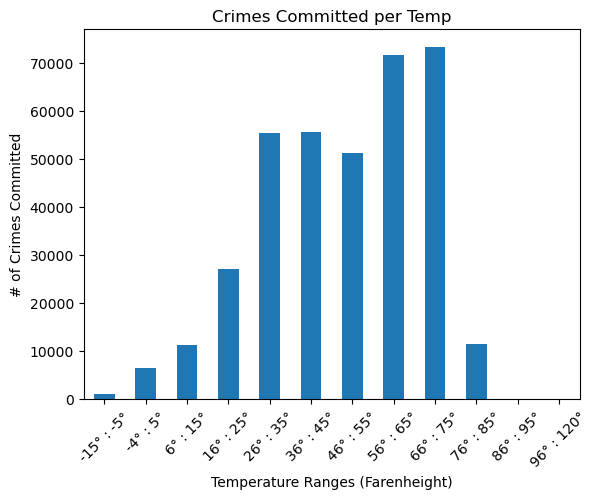

In [67]:
#Plotting Bar graph with Bins
merged_df.groupby("Temperature Ranges")["Primary Type"].count().plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel('Temperature Ranges (Farenheight)')
plt.ylabel("# of Crimes Committed")
plt.title("Crimes Committed per Temp")
plt.show()


In [68]:
merged_df["temperature_2m_max"].value_counts()

temperature_2m_max
74.851700    2142
78.361702    1918
73.321701    1843
77.821701    1741
77.461700    1698
             ... 
13.651701     108
11.941700     107
2.041702      106
15.091702     103
0.871700       94
Name: count, Length: 733, dtype: int64

In [69]:
merged_df['Year'].value_counts()

Year
2012    80939
2013    73660
2016    71170
2014    68069
2015    67780
2017     2843
Name: count, dtype: int64